<a href="https://colab.research.google.com/github/antndlcrx/LLM-for-Social-Science-Research/blob/main/synth_sampling_default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    PreTrainedModel,
    PreTrainedTokenizer,
    PreTrainedTokenizerFast,
)
import torch
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import os
from typing import List, Dict, Tuple, Any
import json

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
mount_point = '/content/drive'
from google.colab import drive
drive.mount(mount_point)

Mounted at /content/drive


In [3]:
!git clone https://github.com/antndlcrx/LLM-for-Social-Science-Research.git

Cloning into 'LLM-for-Social-Science-Research'...
remote: Enumerating objects: 400, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 400 (delta 97), reused 79 (delta 34), pack-reused 239 (from 1)
Receiving objects: 100% (400/400), 16.74 MiB | 12.64 MiB/s, done.
Resolving deltas: 100% (238/238), done.


In [4]:
from google.colab import userdata
HF_TOKEN = userdata.get("HF_LLAMA31")

In [5]:
# model_name = "meta-llama/Meta-Llama-3.1-8B"
# model_name = "meta-llama/Llama-3.1-8B-Instruct"
model_name = "oxford-llms/llama3-1-ox-llms-8b-sft-full"

tokenizer = AutoTokenizer.from_pretrained(model_name, token=HF_TOKEN,
                                          padding_side='left')
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/335 [00:00<?, ?B/s]

In [6]:
model = AutoModelForCausalLM.from_pretrained(model_name,
                                             trust_remote_code=True,
                                             torch_dtype=torch.float16,
                                             device_map='auto',
                                             token=HF_TOKEN,
                                             )

config.json:   0%|          | 0.00/886 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

In [ ]:
# pipeline = transformers.pipeline(
#     "text-generation",
#     model=model_id,
#     model_kwargs={"torch_dtype": torch.bfloat16},
#     device_map="auto",
# )

In [7]:
directory = 'LLM-for-Social-Science-Research/mappings/ESS/2023'

survey_mappings = {}

for filename in os.listdir(directory):
    if filename.endswith('.json'):
        section_name = os.path.splitext(filename)[0]

        with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
            survey_mappings[section_name] = json.load(file)

In [8]:
ess = pd.read_csv("LLM-for-Social-Science-Research/ESS11.csv")

<ipython-input-8-669844dd4aa6>:1: DtypeWarning: Columns (548) have mixed types. Specify dtype option on import or set low_memory=False.
  ess = pd.read_csv("LLM-for-Social-Science-Research/ESS11.csv")


In [9]:
class Mapper:
    def __init__(self, survey_mappings: Dict[str, Dict[str, Any]]):
        self.survey_mappings = survey_mappings
        # Build a mapping from feature names to their sections for quick lookup
        self.feature_to_section = {
            feature: section
            for section, features in self.survey_mappings.items()
            for feature in features
        }

    def map_value(self, feature_name: str, value):
        section = self.feature_to_section.get(feature_name)
        if not section:
            return str(value)  # Feature not found in mappings

        feature_mapping = self.survey_mappings[section].get(feature_name)
        if not feature_mapping:
            return str(value)  # Feature mapping not found

        values_mapping = feature_mapping.get('values', {})
        if pd.isnull(value):
            return "Missing"

        if isinstance(value, float) and value.is_integer():
            value_key = str(int(value))
        elif isinstance(value, (int, np.integer)):
            value_key = str(value)
        else:
            value_key = str(value)

        return values_mapping.get(value_key, str(value))

    def fill_prompt(self, respondent: pd.Series, prompt_template: str):
        placeholders = {}
        placeholder_pattern = re.compile(r"\{(\w+)\}")
        placeholder_names = placeholder_pattern.findall(prompt_template)

        for placeholder in placeholder_names:
            if placeholder in respondent:
                value = respondent[placeholder]
                if placeholder in ['agea']:
                    # Handle numeric fields separately
                    placeholders[placeholder] = str(int(value)) if pd.notnull(value) else f"unknown {placeholder}"
                else:
                    mapped_value = self.map_value(placeholder, value)
                    placeholders[placeholder] = mapped_value
            else:
                placeholders[placeholder] = "Unknown"

        filled_prompt = prompt_template.format(**placeholders)
        return filled_prompt


In [10]:
mapper = Mapper(survey_mappings)

In [11]:
def generate_dialog(survey: pd.DataFrame):
    """
    """

    profile_prompt = """Imagine you are a {agea}-year old {gndr} living in {cntry} in {essround}. Your highest education is {eisced} and your feelings about your income are {hincfel}. On a scale from left (0) to right(10), you would put yourself at {lrscale}."""

    system_dict = {
        "role": "system",
        "content": """You are a helpful AI assistant for public opinion research. You are skillful at using your knowledge to make good judgement about people's preferences when given some background information."""
        }

    question = """
        Qusetion: In your opinion, how often do women get easily offended? Provide a one-word answer using only categories from the list: "never", "rarely", "sometimes", "often", "always", "refuse to answer", "don't know". Do not respond starting with "I would say" or similar ways. Only provide one of the given categories."""

    messages = []
    for idx, respondent in survey.iterrows():
        filled_prompt = mapper.fill_prompt(respondent, profile_prompt)
        user_dict = {"role": "user",
                     "content": filled_prompt + question}
        message = [system_dict, user_dict]
        messages.append(message)

    return messages

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def make_predictions(dialogs, batch_size=8):
    """
    Generate predictions for a batch of dialogs.

    Args:
        dialogs (list): A list of dictionaries containing dialogs to process.
        batch_size (int): Number of dialogs to process in a single batch.

    Returns:
        list: A list of generated completions for the input dialogs.
    """
    completions = []

    with tqdm(total=len(dialogs), desc="Generating predictions", unit="prompt") as pbar:
        for i in range(0, len(dialogs), batch_size):
            batch_dialogs = dialogs[i:i + batch_size]

            inputs = tokenizer.apply_chat_template(
                batch_dialogs,
                tokenize=True,
                add_generation_prompt=True,
                truncation=True, padding=True,
                return_tensors="pt"
                ).to(device)

            with torch.no_grad():
                outputs = model.generate(
                    inputs,
                    max_new_tokens=32,
                    temperature=1.0,
                    do_sample=True,
                    eos_token_id=tokenizer.eos_token_id,
                    pad_token_id=tokenizer.pad_token_id,
                )

            batch_completions = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
            completions.extend(batch_completions)
            pbar.update(len(batch_dialogs))

    return completions


def extract_answers(responses):
    """
    Extracts only the answer part from a list of text responses.

    Args:
        responses (list): A list of response strings, where each string is a complete dialogue.

    Returns:
        list: A list of extracted answers (strings).
    """
    answers = []
    for response in responses:
        # Use regex to match everything after 'assistant\n'
        match = re.search(r"<\|assistant\|>\s*(.+)", response, re.DOTALL)
        if match:
            # Strip whitespace and newlines from the answer
            answer = match.group(1).strip()
            answers.append(answer)
        else:
            # If no match, add a placeholder or leave empty
            answers.append("No answer found")
    return answers

In [13]:
random_subset = ess.sample(300, random_state=42)

In [14]:
dialogs = generate_dialog(random_subset)

In [18]:
responces = make_predictions(dialogs)

Generating predictions: 100%|██████████| 300/300 [02:42<00:00,  1.84prompt/s]


Text(0, 0.5, 'Proportion')

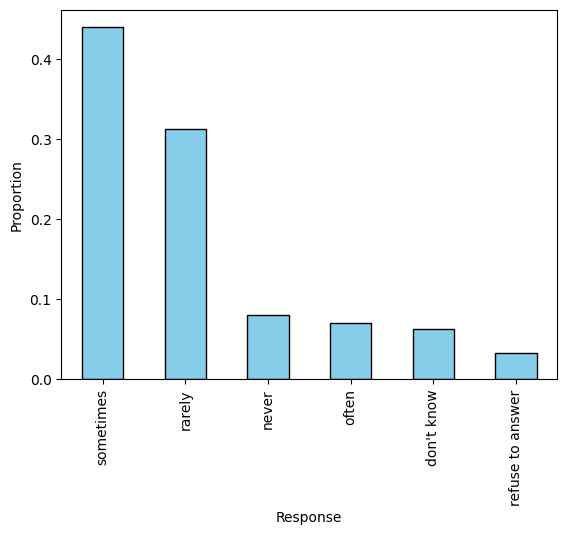

In [19]:
response_list = [response.rstrip(".").lower() for response in extract_answers(responces)]
response_df = pd.DataFrame({'weasoff': response_list})
response_df['weasoff'].value_counts(normalize=True).plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Response')
plt.ylabel('Proportion')

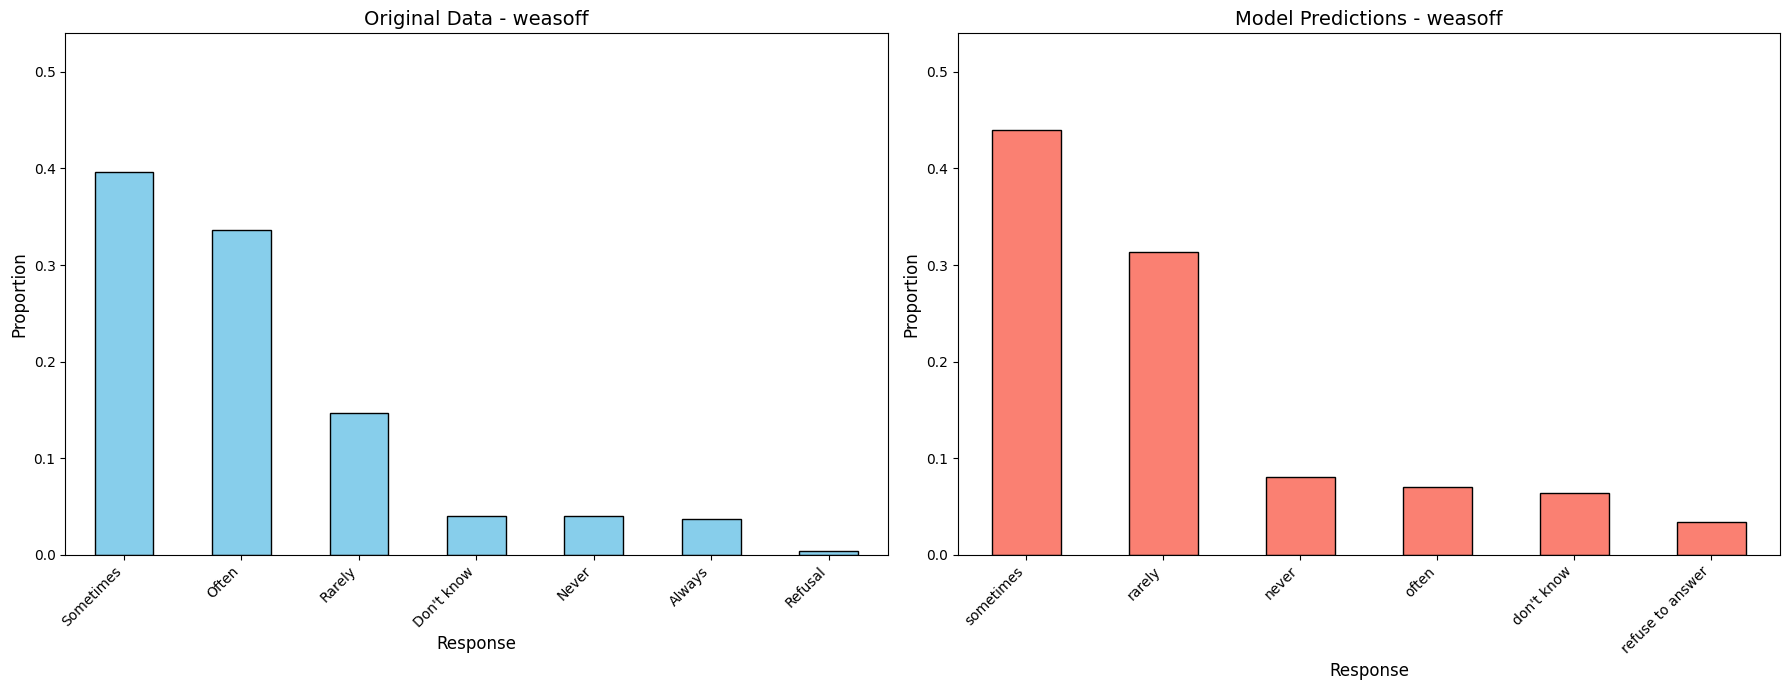

In [20]:
response_df['weasoff_mapped'] = response_df['weasoff'].apply(lambda x: mapper.map_value('weasoff', x))
random_subset['weasoff_mapped'] = random_subset['weasoff'].apply(lambda x: mapper.map_value('weasoff', x))

# Calculate category proportions for original data
original_proportions = random_subset['weasoff_mapped'].value_counts(normalize=True)

# Calculate category proportions for model predictions
response_proportions = response_df['weasoff_mapped'].value_counts(normalize=True)

max_y = max(original_proportions.max(), response_proportions.max())+0.1

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

# Plot original survey data distribution
original_proportions.plot(
    kind='bar',
    color='skyblue',
    edgecolor='black',
    ax=axes[0]
)
axes[0].set_title('Original Data - weasoff', fontsize=14)
axes[0].set_xlabel('Response', fontsize=12)
axes[0].set_ylabel('Proportion', fontsize=12)
axes[0].set_xticklabels(original_proportions.index, rotation=45, ha='right', fontsize=10)
axes[0].set_ylim(0, max_y)  # Set y-axis limit

# Plot model predictions distribution
response_proportions.plot(
    kind='bar',
    color='salmon',
    edgecolor='black',
    ax=axes[1]
)
axes[1].set_title('Model Predictions - weasoff', fontsize=14)
axes[1].set_xlabel('Response', fontsize=12)
axes[1].set_ylabel('Proportion', fontsize=12)
axes[1].set_xticklabels(response_proportions.index, rotation=45, ha='right', fontsize=10)
axes[1].set_ylim(0, max_y)  # Set y-axis limit

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()